# Least Absolute Shrinkage and Selection Operator (LASSO)

## 1. Big Data Challenge: 
A common challenge in modern predictive modeling involves high-dimensional datasets. This scenario is typically defined by:
* **A high-dimensional feature space ($p$)**: We have a vast number of potential predictors, far more than can be practically or reliably included in a single model. We often suspect many of these features are redundant or simply noise.
  * **Example**:
    * A Single Nucleotide Polymorphism, or [SNP](https://www.sciencedirect.com/topics/neuroscience/single-nucleotide-polymorphism) (pronounced "snip"), is the most common type of genetic variation found among people. Each SNP represents difference in a single nucleotide, DNA's building block. To clarify,  at a specific location in the genome, most people might have the sequence: <code>...A A T G <b>C</b> T A G...</code> But in a fraction of the population (typically, at least 1%), that single C might be a T: <code>...A A T G <b>T</b> T A G...</code>.
This single-base difference is a SNP.
     * Imagine a study aiming to predict a patient's risk for a complex, [polygenic](https://www.genomicseducation.hee.nhs.uk/glossary/polygenic-condition/) disease like Alzheimer's.The dataset might include:
       * [4-5 million](https://medlineplus.gov/genetics/understanding/genomicresearch/snp/) SNPs.
       * Data on the expression levels of [20,000 different genes](https://medlineplus.gov/genetics/understanding/basics/gene/).
       * Thousands of [proteomic](https://www.sciencedirect.com/topics/neuroscience/proteomics) or [metabolic](https://pmc.ncbi.nlm.nih.gov/articles/PMC4452245/ ) markers.
    * For each patient, we have millions of potential predictors. It is a biological certainty that the vast majority of these markers are not causally linked to this specific disease. The analytical goal is to sift through this high-dimensional noise to discover the handful of genetic features that are genuinely associated with the outcome.
* **A large sample size ($n$)**: We have sufficient data (a large $n$) to support the training of complex, high-capacity models without severe instability.
  * **Example**:
    * Netflix's recommendation engine.
      * Here $n$ is not just the [300+ million subscribers](https://ir.netflix.net/ir-overview/profile/default.aspx), but the trillions of interaction events collected. This data is a firehose of implicit and explicit user feedback, including
      * viewing behavior,
      * abandonment data,
      * every search query, pause, rewind, fast-forward,
      *  Browsing data.
    *  This massive $n$ allows Netflix to move beyond simple correlations (e.g., "people who like Stranger Things also like The OA") and model the subtle, non-linear interaction patterns (e.g., "users who watch sci-fi on weekdays but comedy on weekends respond well to this specific new release") that are invisible in smaller datasets.
 
In these scenarios, the objective is twofold: to maximize predictive accuracy and to achieve [**parsimony**](https://www.sciencedirect.com/topics/computer-science/parsimony-principle). We want to identify the most critical subset of features that are genuinely associated with the outcome.

This approach **shifts** the analytical focus **from** traditional [**hypothesis-testing**](https://www.sciencedirect.com/science/article/pii/0735675788902070) (where a model is pre-specified based on domain theory) to a hypothesis-generating framework. We leverage statistical methods **to** perform **data-driven discovery**, allowing the algorithm to determine the most impactful variables.

## 2. Variable Selection Methods

### 2.1 The Best Subset

It's the "brute force" method. The idea is simple: just test every single combination of predictors, all $2^p$ of them, and pick the one that gives you the best R-squared, AIC,BIC or whatever metric is being monitored. The problem is that this approach is computationally intractable. The number of models explodes exponentially. Even for a tiny $p=25$, you'd have to test over a million (3,355,4432 to be exact) models. For $p=100$? Impractical. 

### 2.2 Forward Selection

It starts with a null model (a model containing only the intercept, with no predictors). At each step, it tests all variables not yet in the model, one at a time. It selects and adds the single best variable, i.e. the one that provides the most statistically significant improvement to the model's fit (e.g., lowest p-value).This process is repeated, adding one variable at a time, until no remaining variable can improve the model's fit beyond a predefined stopping criterion (like a p-value threshold). This approach drastically reduces the computational burden from an exponential search to a quadratic one, requiring $1 + \frac{p(p+1)}{2}$ model comparisons. For example, with $p=25$ predictors, this method only needs to test 326 models.

### 2.3 Backward Selection

It works in reverse starting with the full model, which includes every single predictor. At each step, it tests the impact of removing each variable currently in the model, one at a time. It then permanently removes the single worst predictor, i.e. the one whose removal least harms the model's fit (e.g., the one with the highest p-value).This elimination process is repeated until removing any more variables would significantly degrade the model's fit. This approach has the same quadratic computational cost as forward selection. 

### 2.4 Issues

While relatively efficient, the core limitation of stepwise selection methods is that they are not guaranteed to find the optimal model.These methods are greedy algorithms as they make the single best "short-sighted" decision at each step. This myopic approach can easily trap the algorithm in a local optimum, causing it to miss the true global optimum.

A classic example below illustrates this failure. 

Imagine we are predicting $Y$ using four variables ($X_1, X_2, X_3, X_4$).The best single-variable model is $Y \sim X_2$.The true best two-variable model is $Y \sim X_1 + X_4$. In this scenario, Forward Selection will inevitably fail. 
  * At Step 1, it compares the four single-variable models: $(X_1)$, $(X_2)$, $(X_3)$, and $(X_4)$. It must select $Y \sim X_2$, as it is the best single predictor.
  * At Step 2, it is now locked into this path. It will only test models that add to $X_2$: $(X_2, X_1)$,  $(X_2,X_3), (X_2, X_4)$.
  * The algorithm will never have the opportunity to test the true best model ($Y \sim X_1 + X_4$). Because it made the "best" decision at Step 1, it is now only searching for models that include $X_2$, and it will never find the superior model that doesn't.

This "path-dependent" nature is the fundamental flaw of greedy selection. 

# 3. Ordinary Least Squares (OLS)

The objective of OLS is to find the vector of coefficients, $\boldsymbol{\beta}$, that minimizes the Residual Sum of Squares (RSS).The RSS is the sum of the squared differences between the observed values ($y_i$) and the values predicted by the model ($\hat{y}_i$). 

Define the vector of residuals (errors), $\boldsymbol{e}$:$$\boldsymbol{e} = \boldsymbol{y} - \hat{\boldsymbol{y}} = \boldsymbol{y} - \mathbf{X}\boldsymbol{\beta}$$

The RSS, which is our objective function $J(\boldsymbol{\beta})$, is the dot product of the residual vector with itself (which is equivalent to the sum of its squared elements):$$J(\boldsymbol{\beta}) = \boldsymbol{e}^T\boldsymbol{e} = (\boldsymbol{y} - \mathbf{X}\boldsymbol{\beta})^T (\boldsymbol{y} - \mathbf{X}\boldsymbol{\beta})$$ 
where:
* $\boldsymbol{y}$ is the $n \times 1$ vector of observed outcomes.
* $\mathbf{X}$ is the $n \times (p+1)$ design matrix of predictors (with an intercept term).
* $\boldsymbol{\beta}$ is the $(p+1) \times 1$ vector of coefficients we are trying to find.

The goal is to find the vector $\hat{\boldsymbol{\beta}}$ that minimizes the objective function, the Residual Sum of Squares.

**Step 1: Expand the Objective Function**: 

$$\begin{aligned}
J(\boldsymbol{\beta}) &= (\boldsymbol{y}^T - (\mathbf{X}\boldsymbol{\beta})^T) (\boldsymbol{y} - \mathbf{X}\boldsymbol{\beta}) \\
J(\boldsymbol{\beta}) &= (\boldsymbol{y}^T - \boldsymbol{\beta}^T\mathbf{X}^T) (\boldsymbol{y} - \mathbf{X}\boldsymbol{\beta}) \\
J(\boldsymbol{\beta}) &= \boldsymbol{y}^T\boldsymbol{y} - \boldsymbol{y}^T\mathbf{X}\boldsymbol{\beta} - \boldsymbol{\beta}^T\mathbf{X}^T\boldsymbol{y} + \boldsymbol{\beta}^T\mathbf{X}^T\mathbf{X}\boldsymbol{\beta} = \boldsymbol{y}^T\boldsymbol{y} - 2\boldsymbol{\beta}^T\mathbf{X}^T\boldsymbol{y} + \boldsymbol{\beta}^T\mathbf{X}^T\mathbf{X}\boldsymbol{\beta}
\end{aligned}$$
Note that, $\boldsymbol{y}^T_{1 \times n}\mathbf{X_{n \times (p+1)}}\boldsymbol{\beta_{(p+1)}}$ and $\boldsymbol{\beta_{1 \times (p+1)}}^T\mathbf{X^T_{(p+1) \times n}}\boldsymbol{y_{n \times 1}}$, are both scalars (i.e., $1 \times 1$ matrices). The transpose of a scalar is just itself. Therefore, they are equal.

**Step 2: Differentiate with Respect to $\boldsymbol{\beta}$**: 

Take the gradient of $J(\boldsymbol{\beta})$ with respect to the vector $\boldsymbol{\beta}$ using two standard rules of [matrix calculus](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf):
$$ \nabla_{\boldsymbol{\beta}} (\boldsymbol{\beta}^T\boldsymbol{a}) = \boldsymbol{a}$$

$$\nabla_{\boldsymbol{\beta}}(\boldsymbol{\beta}^T\mathbf{A}\boldsymbol{\beta}) = 2\mathbf{A}\boldsymbol{\beta}$$

Let's apply these rules to each term in our expanded function:$$\nabla_{\boldsymbol{\beta}} J(\boldsymbol{\beta}) = \nabla_{\boldsymbol{\beta}}(\boldsymbol{y}^T\boldsymbol{y}) - \nabla_{\boldsymbol{\beta}}(2\boldsymbol{\beta}^T\mathbf{X}^T\boldsymbol{y}) + \nabla_{\boldsymbol{\beta}}(\boldsymbol{\beta}^T\mathbf{X}^T\mathbf{X}\boldsymbol{\beta}) =\mathbf{0} - 2\mathbf{X}^T\boldsymbol{y} + 2(\mathbf{X}^T\mathbf{X})\boldsymbol{\beta}$$

**Step 3: Set Gradient to Zero and Solve** 

To find the minimum, set the gradient to the zero vector ($\mathbf{0}$) and solve for the coefficient vector, which we now call $\hat{\boldsymbol{\beta}}$ (the "estimator").

$$2(\mathbf{X}^T\mathbf{X})\hat{\boldsymbol{\beta}} - 2\mathbf{X}^T\boldsymbol{y} = \mathbf{0} \rightarrow (\mathbf{X}^T\mathbf{X})\hat{\boldsymbol{\beta}} = \mathbf{X}^T\boldsymbol{y}$$

Finally, to isolate $\hat{\boldsymbol{\beta}}$, pre-multiply both sides by the inverse of the $(\mathbf{X}^T\mathbf{X})$ matrix:$$(\mathbf{X}^T\mathbf{X})^{-1}(\mathbf{X}^T\mathbf{X})\hat{\boldsymbol{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\boldsymbol{y}$$Since a matrix multiplied by its inverse is the identity matrix ($\mathbf{I}$), we get the final closed-form solution for OLS:$$\hat{\boldsymbol{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\boldsymbol{y}$$

While **OLS** is highly effective at finding an unbiased model, it often fails in modern data settings, particularly those with high dimensionality. OLS is prone to [overfitting](https://www.nature.com/articles/nmeth.3968) when is large, leading to models with high variance that do not generalize well to new data. It is also notoriously unstable in the presence of [multicollinearity](https://www.sciencedirect.com/topics/mathematics/multicollinearity-problem).

**LASSO** ($L1$ regression) directly solves these problems by introducing a penalty term that regularizes the model. This penalty shrinks coefficients to reduce variance and most performs automatic feature selection by forcing the coefficients of less-informative (correlated) predictors to exactly zero.

# 4.Regularized Regression 

## 4.1 LASSO ($L1$)

### 4.1.1 Objective

The goal of LASSO is to find the coefficient vector $\boldsymbol{\beta}$ that minimizes the following objective function:$$J_{\text{LASSO}}(\boldsymbol{\beta}) = \underbrace{\text{RSS}(\boldsymbol{\beta})}_{\text{Data Fit}} + \underbrace{\lambda \cdot \text{L1-Penalty}(\boldsymbol{\beta})}_{\text{Regularization}}$$

In the matrix form the objective function is:

$$J(\boldsymbol{\beta}) =  \|\boldsymbol{y} - \mathbf{X}\boldsymbol{\beta}\|_2^2 + \lambda \|\boldsymbol{\beta}\|_1$$

The more intuitive scalar form shows the per-observation calculation:

$$J(\boldsymbol{\beta}) = \sum_{i=1}^{N} (y_i - (\beta_0 + \sum_{j=1}^{p} x_{ij}\beta_j))^2 + \lambda \sum_{j=1}^{p} |\beta_j|
$$
  * $y_i$ is the observed value for the $i$-th sample.
  * $x_{ij}$ is the value of the $j$-th predictor for the $i$-th sample.
  * $\beta_j$ is the coefficient for the $j$-th predictor.
  * $\lambda$ is the non-negative **tuning parameter** that controls the strength of the penalty.
  * $\lambda \sum_{j=1}^{p} |\beta_j|$ is the **L1-penalty**.

Note that the sum starts from $j=1$, not $j=0$. The intercept term, $\beta_0$, is **not penalized**.

Also, note that the OLS closed-form solution $\hat{\boldsymbol{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\boldsymbol{y}$ cannot be used for LASSO.The problem is the $L1$-norm, $\lambda \sum |\beta_j|$. The absolute value function $f(z) = |z|$ is non-differentiable at the point $z=0$. Because the gradient is undefined at zero, standard gradient-based optimization methods (e.g., gradient descent) can not be used directly.

### 4.1.2 LASSO Fitting

#### 4.1.2.1 Overveiw

The sharp "corners" of the L1 penalty (the $\lambda|\beta_j|$ term) are precisely what causes coefficients to be set to zero, but they also mean the objective function **is not differentiable everywhere**. This prevents us from using standard, smooth optimization methods like Gradient Descent. Instead, we need specialized algorithms. One of the most common and powerful choices is Coordinate Descent, which is used by default in libraries like [`scikit-learn`](https://scikit-learn.org/stable/).

The intuitive algorithm works as follows:

* **Initialize**: Start with all coefficients $\beta_j$ at some value (e.g., initialize randomly or all zeros).
* **Cycle**: Repeatedly cycle through the predictors, one at a time, from $j = 1$ to $p$.
  * **For each predictor** $j$:
    * Temporarily "freeze" all other coefficients ($\beta_{k \neq j}$) at their current values.
    * Find the single best value for $\beta_j$. This 1D problem has an exact, simple solution called the [**soft thresholding operator**](https://www.tensorflow.org/probability/api_docs/python/tfp/math/soft_threshold).
      * Each coefficient $\beta_j$ will be either snapped to zero or moved towards zero. 
* **Repeat**: The algorithm performs this full cycle updating $\beta_1, \beta_2, \dots, \beta_p$ in sequence, over and over again.
* **Convergence**: The process stops when the coefficient vector $\boldsymbol{\beta}$ no longer changes meaningfully between full iterations.

Because the LASSO objective is convex, this simple iterative process is guaranteed to find the single global minimum.

#### 4.1.2.2 The Math Behind $L1$ Optimization 

**Objective function**:

$$J(\boldsymbol{\beta}) = \frac{1}{2N} \sum_{i=1}^{N} \left(y_i - \sum_{k=1}^{p} x_{ik}\beta_k\right)^2 + \lambda \sum_{k=1}^{p} |\beta_k|$$
This scaling is common in machine learning (e.g., in sklearn) as it makes the loss term an average (the Mean Squared Error) and simplifies the resulting gradient.

**GOAL**: find the value of $\beta_j$ that minimizes the LASSO objective (this is done for each $j=1$ to $p$).

1. **Isolate** $\mathbf{\beta_j}$:

$$J(\beta_j) = \frac{1}{2N} \sum_{i=1}^{N} \left(y_i - \sum_{k \neq j} x_{ik}\beta_k - x_{ij}\beta_j\right)^2 + \lambda \sum_{k \neq j} |\beta_k| + \lambda |\beta_j|$$

  Note that $\lambda \sum_{k \neq j} |\beta_k|$ is a constant and can be ignored for minimization.

2. **Define the Partial Residual**:

$$r_{i,j} = y_i - \sum_{k \neq j} x_{ik}\beta_k$$

  This $r_{i,j}$ represents the "error" of the model without the contribution of predictor $j$. 

3. **Create the 1D Objective Function**

$$ \min_{\beta_j} \left( \underbrace{\frac{1}{2N} \sum_{i=1}^{N} (r_{i,j} - x_{ij}\beta_j)^2}_{\text{$L(\beta_j)$}} + \lambda |\beta_j| \right)$$

4. **Solve the 1D Problem using Subgradients**. Assume the data is standardized, i.e.  $\sum_{i=1}^{N} x_{ij}^2 = N$.

$$\frac{\partial L}{\partial \beta_j} = \frac{\partial}{\partial \beta_j} \left( \frac{1}{2N} \sum_{i=1}^{N} (r_{i,j} - x_{ij}\beta_j)^2 \right)$$$$
= \frac{1}{2N} \sum_{i=1}^{N} 2(r_{i,j} - x_{ij}\beta_j) \cdot (-x_{ij})$$$$= -\frac{1}{N} \sum_{i=1}^{N} x_{ij}(r_{i,j} - x_{ij}\beta_j)$$$$= -\frac{1}{N} \sum_{i=1}^{N} x_{ij}r_{i,j} + \frac{1}{N} \beta_j \sum_{i=1}^{N} x_{ij}^2$$

Now, apply the standardization, $\sum_{i=1}^{N} x_{ij}^2 = N$:$$\frac{\partial L}{\partial \beta_j} = -\frac{1}{N} \sum_{i=1}^{N} x_{ij}r_{i,j} + \frac{1}{N} \beta_j (N)$$$$\frac{\partial L}{\partial \beta_j} = -\frac{1}{N} \sum_{i=1}^{N} x_{ij}r_{i,j} + \beta_j$$

Let's define $\rho_j = \frac{1}{N} \sum_{i=1}^{N} x_{ij}r_{i,j}$. 

This $\rho_j$ (rho) term now represents the **sample covariance** between predictor $j$ and the partial residuals. So, the gradient of the RSS part is simply: $\frac{\partial L}{\partial \beta_j} = -\rho_j + \beta_j$. 

Set the full gradient to $0$:

$$-\rho_j + \beta_j + \underbrace{\partial(\lambda |\beta_j|)}_{\text{Subgradient}} = 0$$

There are, therefore, three cases.

* **Case 1**: $\beta_j > 0$ and the subgradient is $\lambda$:

$$-\rho_j + \beta_j + \lambda = 0 \implies \beta_j = \rho_j - \lambda$$. 

  This is only possible if $\rho_j > \lambda$.

* **Case 2**: $\beta_j < 0$ and the subgradient is $-\lambda$:

$$-\rho_j + \beta_j - \lambda = 0 \implies \beta_j = \rho_j + \lambda$$
 
This is only possible if $\rho_j < -\lambda$.

* **Case 3**: $\beta_j = 0$:
  
The subgradient is any value $v \in [-\lambda, +\lambda]$.

$$-\rho_j + (0) + v = 0 \implies v = \rho_j$$

For this to be a valid solution, $v$ must be in its allowed range:

$$\rho_j \in [-\lambda, +\lambda] \implies |\rho_j| \le \lambda$$

The coefficient snaps to zero if the sample covariance $\rho_j$ is smaller in magnitude than the penalty parameter $\lambda$.

The Update Rule:

$$ 
\hat{\beta}_j \leftarrow
\begin{cases}
\rho_j - \lambda & \text{if } \rho_j > \lambda \\
\rho_j + \lambda & \text{if } \rho_j < -\lambda \\
0 & \text{if } |\rho_j| \le \lambda
\end{cases}
$$

This can be written compactly using the **Soft-Thresholding Operator**, $S_{\lambda}(\cdot)$:

$$\hat{\beta}_j \leftarrow S_{\lambda}(\rho_j)$$

where:
* **$S_{\lambda}(a) = \text{sign}(a) \cdot \max(0, |a| - \lambda)$**

To summarize, if the magnitude of the sample covariance (between the predictor $j$ and the partial residuals) is less than or equal to the penalty $\lambda$, the coefficient is snapped to exactly zero. Otherwise, if the covariance is stronger than the penalty, the coefficient is set to this covariance value, which is then shrunk towards zero by the exact amount $\lambda$.

This is the standard form used in most [textbooks](https://hastie.su.domains/StatLearnSparsity/) and `sklearn`. The penalty parameter $\lambda$ from the objective function is *exactly* the threshold $\lambda$ used in the operator. 

## 4.2 RIDGE ($L2$)

The objective function $J(\boldsymbol{\beta})$ is:

$$J(\boldsymbol{\beta}) = \text{RSS} + \lambda \sum_{j=1}^{p} \beta_j^2$$

In matrix form, the RSS is $(\mathbf{y} - \mathbf{X}\boldsymbol{\beta})^T(\mathbf{y} - \mathbf{X}\boldsymbol{\beta})$ and the L2 penalty is $\lambda(\boldsymbol{\beta}^T\boldsymbol{\beta})$.

$$J(\boldsymbol{\beta}) = (\mathbf{y} - \mathbf{X}\boldsymbol{\beta})^T(\mathbf{y} - \mathbf{X}\boldsymbol{\beta}) + \lambda \boldsymbol{\beta}^T\boldsymbol{\beta} = \mathbf{y}^T\mathbf{y} - 2\boldsymbol{\beta}^T\mathbf{X}^T\mathbf{y} + \boldsymbol{\beta}^T\mathbf{X}^T\mathbf{X}\boldsymbol{\beta} + \lambda \boldsymbol{\beta}^T\boldsymbol{\beta}$$

Differentiate with Respect to $\boldsymbol{\beta}$:

$$\nabla_{\boldsymbol{\beta}} J(\boldsymbol{\beta}) = \nabla_{\boldsymbol{\beta}}(\mathbf{y}^T\mathbf{y}) - \nabla_{\boldsymbol{\beta}}(2\boldsymbol{\beta}^T\mathbf{X}^T\mathbf{y}) + \nabla_{\boldsymbol{\beta}}(\boldsymbol{\beta}^T\mathbf{X}^T\mathbf{X}\boldsymbol{\beta}) + \nabla_{\boldsymbol{\beta}}(\lambda \boldsymbol{\beta}^T\boldsymbol{\beta}) = \mathbf{0} - 2\mathbf{X}^T\mathbf{y} + 2(\mathbf{X}^T\mathbf{X})\boldsymbol{\beta} + 2\lambda\mathbf{I}\boldsymbol{\beta}$$

Set Gradient to Zero and Solve:

$$\mathbf{0} = -2\mathbf{X}^T\mathbf{y} + 2(\mathbf{X}^T\mathbf{X})\hat{\boldsymbol{\beta}}_{\text{ridge}} + 2\lambda\mathbf{I}\hat{\boldsymbol{\beta}}_{\text{ridge}}$$

$$\mathbf{X}^T\mathbf{y} = (\mathbf{X}^T\mathbf{X})\hat{\boldsymbol{\beta}}_{\text{ridge}} + \lambda\mathbf{I}\hat{\boldsymbol{\beta}}_{\text{ridge}}$$

$$\mathbf{X}^T\mathbf{y} = (\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})\hat{\boldsymbol{\beta}}_{\text{ridge}}$$

$$(\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y} = \underbrace{(\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}(\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})}_{\text{$\mathbf{I}$}}\hat{\boldsymbol{\beta}}_{\text{ridge}}$$

This gives the final closed-form solution for Ridge Regression:$$\hat{\boldsymbol{\beta}}_{\text{ridge}} = (\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$$

Unlike LASSO, Ridge Regression has a closed-form solution because its objective function is smooth and differentiable everywhere. The $L2$ penalty $\lambda \boldsymbol{\beta}^T\boldsymbol{\beta}$ does not have the sharp "corners" of the $L1$ penalty.This solution directly addresses the OLS problem of multicollinearity. When predictors are highly correlated, the $\mathbf{X}^T\mathbf{X}$ matrix becomes singular (or near-singular), making its inverse $(\mathbf{X}^T\mathbf{X})^{-1}$ highly unstable or impossible to compute. By adding the $\lambda\mathbf{I}$ term, Ridge adds a positive value to the diagonal of $\mathbf{X}^T\mathbf{X}$, guaranteeing the resulting matrix is invertible. This "ridge" on the diagonal stabilizes the coefficients and, as a side effect, shrinks them toward zero, reducing model variance and preventing overfitting.

# 5. Geometric Interpretation

## 5.1 The LASSO Solution: Intersection of RSS Contours and the L1 Constraint

### 5.1.1 Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from typing import Tuple, List, Dict

### 5.1.2 Configuration

In [2]:
# Data Generation
RANDOM_SEED: int = 42
N_SAMPLES_PER_CLUSTER: int = 10
BASE_POINTS: np.ndarray = np.array([
    [1.5, 3.5], [2.5, 1.5], [3.5, 4.5], [4.5, 2.5], [5.5, 5.0]
])
NOISE_STD_X: float = 0.5
NOISE_STD_Y: float = 2.0
TRUE_BETAS: np.ndarray = np.array([2.5, 1.0])

# Model Fitting
# We will fit OLS and LASSO for these three alpha/lambda values
LAMBDAS_TO_PLOT: List[float] = [10.0, 15.0, 20.0]
MODEL_TOLERANCE: float = 1e-8

# Plotting Grid
# Increased grid size for smoother contours over a larger area
GRID_SIZE: int = 900 
GRID_MARGIN: float = 25.0  # Default margin
NUM_CONTOUR_LEVELS: int = 5 # Number of contours to show
# Set to a tuple like (-5, 5) to override automatic plot limits
MANUAL_X_LIMITS: Tuple[float, float] | None = None
MANUAL_Y_LIMITS: Tuple[float, float] | None = None

### 5.1.3 Functions

In [3]:
def generate_data(
    n_per_cluster: int,
    base_pts: np.ndarray,
    true_coefs: np.ndarray,
    noise_x: float,
    noise_y: float,
    seed: int
) -> Tuple[np.ndarray, np.ndarray, int]:
    """
    Generates the clustered sample data.
    """
    np.random.seed(seed)
    
    n_clusters: int = base_pts.shape[0]
    n_samples: int = n_per_cluster * n_clusters
    
    # Repeat each base point n_per_cluster times
    x_base: np.ndarray = np.repeat(base_pts, n_per_cluster, axis=0)
    
    # Add noise to create X
    x: np.ndarray = x_base + np.random.randn(n_samples, 2) * noise_x
    
    # Create y using true coefficients and add noise
    y: np.ndarray = x.dot(true_coefs) + np.random.randn(n_samples) * noise_y
    
    return x, y, n_samples


def fit_models(
    x: np.ndarray, y: np.ndarray, lambdas: List[float], tol: float
) -> Tuple[np.ndarray, Dict[float, np.ndarray]]:
    """
    Fits OLS and LASSO models for each specified lambda.
    
    Returns:
        - OLS solution coefficients.
        - A dictionary mapping {lambda: lasso_solution_coefficients}.
    """
    # OLS solution
    ols: LinearRegression = LinearRegression(fit_intercept=False)
    ols.fit(x, y)
    ols_solution: np.ndarray = ols.coef_
    print(f"OLS Solution (b1, b2): {ols_solution}")
    
    # LASSO solutions
    lasso_solutions: Dict[float, np.ndarray] = {}
    for lambda_val in lambdas:
        lasso: Lasso = Lasso(alpha=lambda_val, fit_intercept=False, tol=tol)
        lasso.fit(x, y)
        lasso_solutions[lambda_val] = lasso.coef_
        print(f"Lasso (lambda={lambda_val}) Solution: {lasso_solutions[lambda_val]}")
        
    return ols_solution, lasso_solutions


def calculate_rss_grid(
    x: np.ndarray, y: np.ndarray, b1: np.ndarray, b2: np.ndarray
) -> np.ndarray:
    """
    Calculates the RSS for every (b1, b2) pair on the grid in a 
    vectorized way.
    """
    # Reshape grid and y for broadcasting
    # b_flat is (grid_size*grid_size, 2)
    b_flat: np.ndarray = np.stack([b1.ravel(), b2.ravel()], axis=1)
    
    # y_col is (n_samples, 1)
    y_col: np.ndarray = y[:, np.newaxis]
    
    # Calculate all predictions at once
    # x is (n_samples, 2), b_flat.T is (2, grid_size*grid_size)
    # all_preds is (n_samples, grid_size*grid_size)
    all_preds: np.ndarray = x @ b_flat.T
    
    # Calculate all residuals
    # y_col broadcasts against all_preds
    # all_residuals is (n_samples, grid_size*grid_size)
    all_residuals: np.ndarray = y_col - all_preds
    
    # Sum of squares for each (b1, b2) pair
    # rss_flat is (grid_size*grid_size,)
    rss_flat: np.ndarray = np.sum(all_residuals**2, axis=0)
    
    # Reshape back to grid shape
    return rss_flat.reshape(b1.shape)


def calculate_loss_grids(
    x: np.ndarray, 
    y: np.ndarray, 
    ols_solution: np.ndarray, 
    grid_size: int, 
    margin: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates the coordinate and RSS grids for plotting.
    """
    # Create a grid of b1 and b2 values
    b1_range: np.ndarray = np.linspace(
        ols_solution[0] - margin, ols_solution[0] + margin, grid_size
    )
    b2_range: np.ndarray = np.linspace(
        ols_solution[1] - margin, ols_solution[1] + margin, grid_size
    )
    b1_grid, b2_grid = np.meshgrid(b1_range, b2_range)
    
    # Calculate RSS (Residual Sum of Squares) for every point on the grid
    print(f"Calculating RSS grid ({grid_size}x{grid_size} points)...")
    rss_grid: np.ndarray = calculate_rss_grid(x, y, b1_grid, b2_grid)
    
    return b1_grid, b2_grid, rss_grid


def plot_classic_lasso_contour(
    ax: plt.Axes,
    b1_grid: np.ndarray,
    b2_grid: np.ndarray,
    rss_grid: np.ndarray,
    ols_sol: np.ndarray,
    lasso_sol: np.ndarray,
    lambda_val: float,
    lasso_rss_val: float
) -> None:
    """
    Plots the classic 2D LASSO contour graph onto a specific axis.
    """
    
    # 1. Define the specific RSS contour levels
    ols_rss: float = np.min(rss_grid)
    end_level: float = lasso_rss_val
    
    # Create levels from OLS (start) to LASSO (end)
    # We add +2 to get N levels *between* OLS and LASSO
    all_levels: np.ndarray = np.linspace(ols_rss, end_level, NUM_CONTOUR_LEVELS + 2)
    
    # Skip the 0-th level (the OLS solution itself)
    # and take unique values to handle edge cases where
    # ols_rss is very close to lasso_rss_val.
    all_levels = np.unique(all_levels[1:])

    # 2. Plot the RSS Contours (ellipses)
    ax.contour(b1_grid, b2_grid, rss_grid, 
               levels=all_levels, cmap='Blues_r', alpha=0.7)
    
    # Re-plot the "touching" contour with a thicker line
    ax.contour(b1_grid, b2_grid, rss_grid, 
               levels=[lasso_rss_val], cmap='Blues_r', linewidths=2)

    # 3. Plot the OLS Solution (center of ellipses)
    ax.scatter(ols_sol[0], ols_sol[1],
               marker='x', s=150, c='blue', label='OLS Solution')

    # 4. Create the L1 "Diamond" Constraint
    # The solution lies on the boundary t = |b1| + |b2|
    t: float = np.sum(np.abs(lasso_sol))
    
    diamond_x: List[float] = [t, 0, -t, 0, t]
    diamond_y: List[float] = [0, t, 0, -t, 0]

    ax.plot(diamond_x, diamond_y, 'r-',
             label=f'L1 Constraint: |b1|+|b2| <= {t:.2f}')

    # 5. Plot the LASSO Solution
    ax.scatter(lasso_sol[0], lasso_sol[1],
               marker='o', s=150, c='red', label='LASSO Solution')

    ax.set_xlabel(r'$\beta_1$', fontsize=12)
    ax.set_title(f'LASSO 2D Path (lambda = {lambda_val})', fontsize=16)

    ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
    ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)
    
    # Enforce equal aspect ratio
    ax.set_aspect('equal', adjustable='box')


def plot_lasso_comparison(
    x: np.ndarray,
    y: np.ndarray,
    b1_grid: np.ndarray,
    b2_grid: np.ndarray,
    rss_grid: np.ndarray,
    ols_solution: np.ndarray,
    lasso_solutions: Dict[float, np.ndarray],
    plot_limit_dist: float | None = None,
    manual_xlim: Tuple[float, float] | None = None,
    manual_ylim: Tuple[float, float] | None = None
) -> None:
    """
    Creates the 3-panel side-by-side comparison plot.
    """
    lambdas: List[float] = list(lasso_solutions.keys())
    
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
    
    fig.suptitle('LASSO Coefficient Path vs. OLS Solution', fontsize=20)
    
    for i, lambda_val in enumerate(lambdas):
        ax: plt.Axes = axes[i]
        lasso_sol: np.ndarray = lasso_solutions[lambda_val]
        
        # Calculate the specific RSS value at the LASSO solution
        predictions: np.ndarray = x @ lasso_sol
        residuals: np.ndarray = y - predictions
        lasso_rss: float = np.sum(residuals**2)
        
        plot_classic_lasso_contour(
            ax, b1_grid, b2_grid, rss_grid,
            ols_solution, lasso_sol, lambda_val, lasso_rss
        )
        if i == 0:
            ax.set_ylabel(r'$\beta_2$', fontsize=12)

    # Determine plot boundaries
    if manual_xlim is not None and manual_ylim is not None:
        print(f"Using manual plot limits: x={manual_xlim}, y={manual_ylim}")
        axes[0].set_xlim(manual_xlim)
        axes[0].set_ylim(manual_ylim)
    elif plot_limit_dist is not None:
        # Center the plot around 0,0
        x_center, y_center = 0.0, 0.0
        print(f"Using automatic plot limits: [+/-{plot_limit_dist:.2f}]")
        axes[0].set_xlim(x_center - plot_limit_dist, x_center + plot_limit_dist)
        axes[0].set_ylim(y_center - plot_limit_dist, y_center + plot_limit_dist)
    else:
        # Fallback, should not happen if main() logic is correct
        print("Warning: No plot limits set. Using matplotlib defaults.")
        pass

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 5.1.4 Main Script 

In [4]:
def plot_lasso() -> None:
    """
    Main function to run the data generation, model fitting,
    and plotting.
    """
    # 1. Generate Data
    x, y, n_samples = generate_data(
        N_SAMPLES_PER_CLUSTER, BASE_POINTS, TRUE_BETAS, 
        NOISE_STD_X, NOISE_STD_Y, RANDOM_SEED
    )
    
    # 2. Fit Models
    ols_solution, lasso_solutions = fit_models(
        x, y, LAMBDAS_TO_PLOT, MODEL_TOLERANCE
    )
    
    # 3. Calculate Grids
    print("Calculating plot and grid boundaries...")
    
    plot_limit_dist: float | None = None
    x_center, y_center = 0.0, 0.0
    grid_margin_x: float = 0.0
    grid_margin_y: float = 0.0
    
    if MANUAL_X_LIMITS is None or MANUAL_Y_LIMITS is None:
        print("Calculating automatic plot boundaries...")
        # Find all points that define the plot limits
        all_points_for_limits: List[np.ndarray] = [ols_solution]
        all_points_for_limits.extend(lasso_solutions.values())
        for sol in lasso_solutions.values():
            t: float = np.sum(np.abs(sol))
            all_points_for_limits.extend([
                np.array([t, 0]), np.array([-t, 0]),
                np.array([0, t]), np.array([0, -t])
            ])
        all_points_np: np.ndarray = np.array(all_points_for_limits)
        
        # 1. Determine the PLOT limit (the viewing window)
        max_dist_x: float = np.max(np.abs(all_points_np[:, 0] - x_center))
        max_dist_y: float = np.max(np.abs(all_points_np[:, 1] - y_center))
        # This is the final plot limit (half-width)
        plot_limit_dist = max(max_dist_x, max_dist_y) * 1.2 # 20% pad
        print(f"Automatic plot limits calculated: [+/-{plot_limit_dist:.2f}]")
        
        # 2. Determine the GRID margin (the calculation area)
        grid_margin_x = abs(ols_solution[0] - x_center) + plot_limit_dist
        grid_margin_y = abs(ols_solution[1] - y_center) + plot_limit_dist
    
    else:
        print("Using manual plot limits for grid calculation.")
        x_min, x_max = MANUAL_X_LIMITS
        y_min, y_max = MANUAL_Y_LIMITS
        # Find the distance from OLS center to the furthest corner of the manual box
        grid_margin_x = max(abs(ols_solution[0] - x_min), abs(ols_solution[0] - x_max))
        grid_margin_y = max(abs(ols_solution[1] - y_min), abs(ols_solution[1] - y_max))

    # Add a small buffer so contours don't end exactly at the plot edge
    grid_margin_dynamic: float = max(grid_margin_x, grid_margin_y) * 1.1 
    
    print(f"Calculating grid with margin: {grid_margin_dynamic:.2f}")

    b1_grid, b2_grid, rss_grid = calculate_loss_grids(
        x, y, ols_solution, GRID_SIZE, grid_margin_dynamic
    )
    
    # 4. Generate the final 3-panel plot
    print(f"\nDisplaying 3-panel comparison plot...")
    plot_lasso_comparison(
        x, y, b1_grid, b2_grid, rss_grid, ols_solution, lasso_solutions,
        plot_limit_dist=plot_limit_dist,
        manual_xlim=(-6.5,6.5),
        manual_ylim=(-6.5,6.5)
    )
    
    print("All plots complete.")

### 5.1.5 The LASSO Intersection Plots

OLS Solution (b1, b2): [2.39792215 1.07149962]
Lasso (lambda=10.0) Solution: [2.13372055 0.56668381]
Lasso (lambda=15.0) Solution: [2.00161967 0.31427598]
Lasso (lambda=20.0) Solution: [1.86951881 0.06186813]
Calculating plot and grid boundaries...
Calculating automatic plot boundaries...
Automatic plot limits calculated: [+/-3.24]
Calculating grid with margin: 6.20
Calculating RSS grid (900x900 points)...

Displaying 3-panel comparison plot...
Using manual plot limits: x=(-6.5, 6.5), y=(-6.5, 6.5)


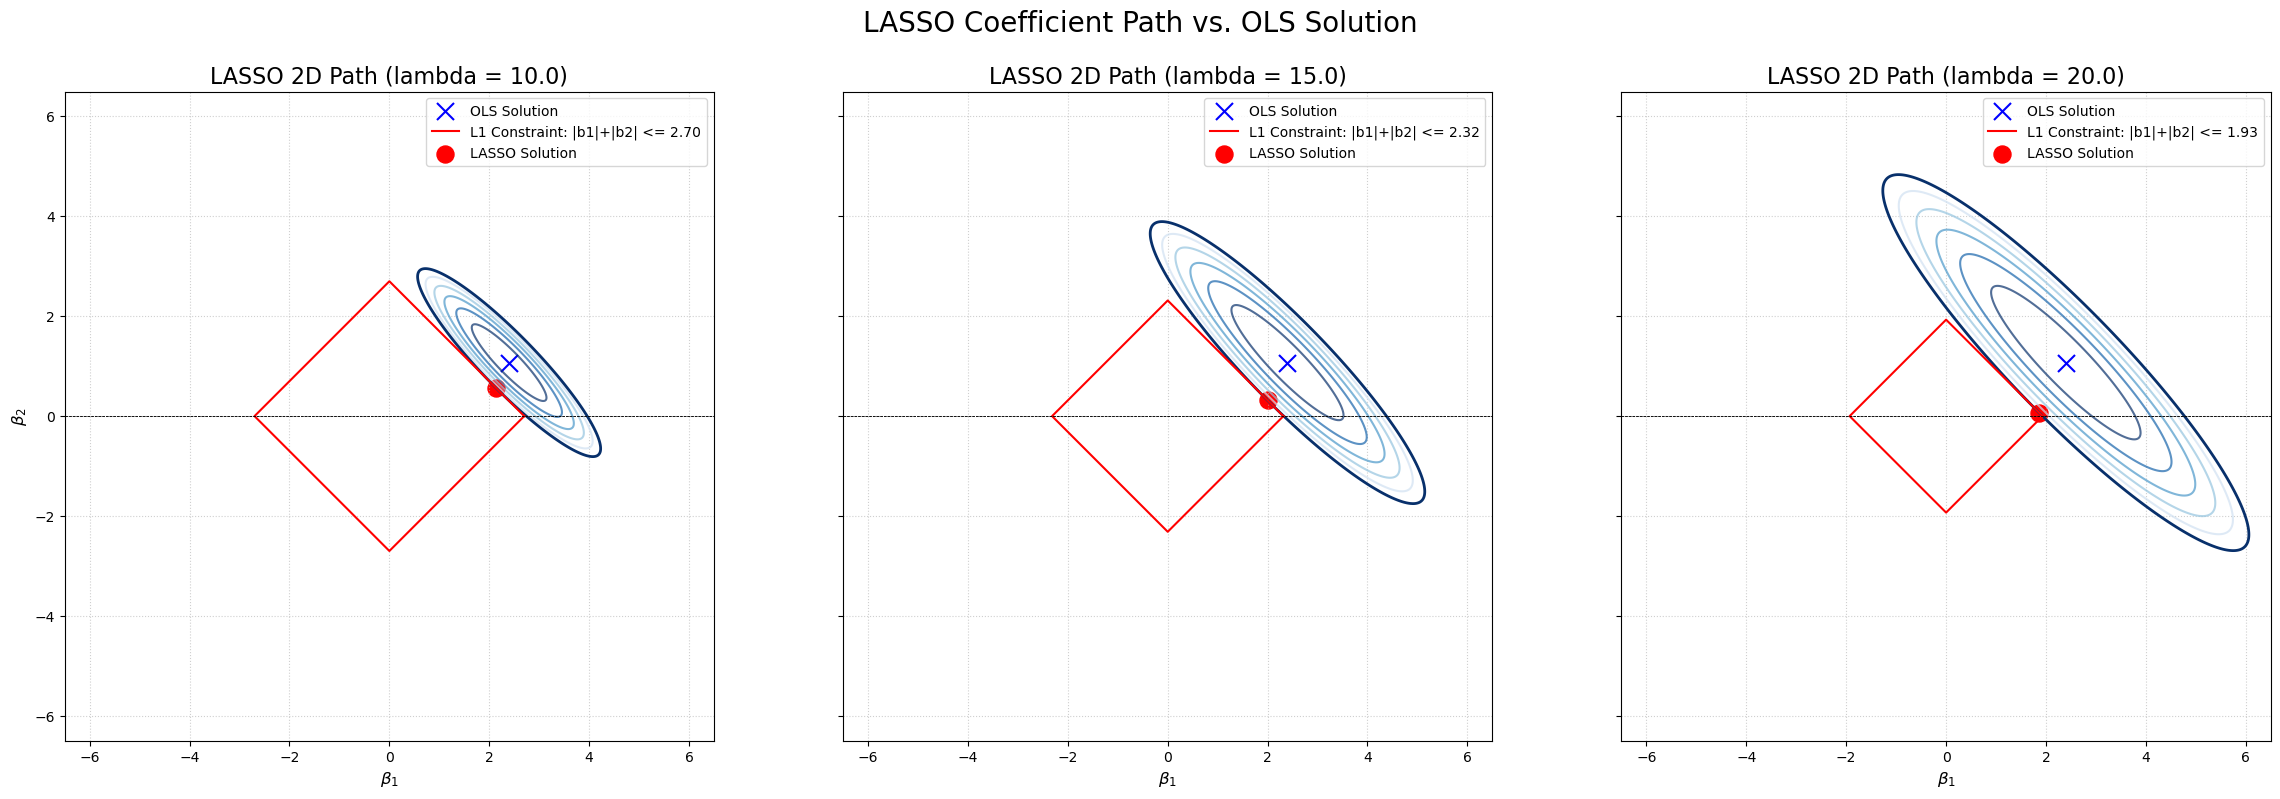

All plots complete.


In [5]:
plot_lasso()

The blue ellipses represent the contour plot for the **RSS**. Every point along a single ellipse corresponds to a combination of coefficients that produces the exact same RSS value. A larger value of $\lambda$ corresponds to a smaller $L1$-norm constraint (a smaller 'diamond’),  which induces greater shrinkage and can force coefficients to exactly zero.

## 5.2 From LASSO to Elastic Net

### 5.2.1 Overview

Elastic Net is a regularized linear regression model that linearly combines the $L1$ (LASSO) and $L2$ (Ridge) penalties.

The most common formulation, used by libraries like `scikit-learn`, defines the objective using two parameters:
* $\alpha$: The overall strength of the regularization (identical to $\lambda$ in LASSO/Ridge)
* $\rho$ (rho): The "L1 ratio," which controls the mix between $L1$ and $L2$.
  * If $\rho = 1$, it is a pure LASSO regression.
  * If $\rho = 0$, it is a pure Ridge regression.

The objective function $J(\boldsymbol{\beta})$ to minimize is:

$$J(\boldsymbol{\beta}) = \underbrace{ \frac{1}{2N} \sum_{i=1}^{N} (y_i - \mathbf{x}_i^T\boldsymbol{\beta})^2 }_{\text{RSS (Loss)}} + \underbrace{ \alpha \rho \sum_{j=1}^{p} |\beta_j| }_{\text{L1 Penalty (LASSO)}} + \underbrace{ \frac{1}{2} \alpha (1-\rho) \sum_{j=1}^{p} \beta_j^2 }_{\text{L2 Penalty (Ridge)}}$$

Changing the $L1$ ratio ($\rho$) morphs the shape of the penalty contour from a perfect circle (Ridge, $\rho=0$) to a perfect diamond (LASSO, $\rho=1$).

### 5.2.2. Visualizing the Elastic Net Constraint Region

#### 5.2.2.1 Libraries

In [6]:
from typing import Optional

#### 5.2.2.2 Functions

In [7]:
def plot_lp_norm(
    ax: plt.Axes, 
    p: float, 
    radius: float = 1.0, 
    color: str = 'blue', 
    title: Optional[str] = None
) -> None:
    """
    Plots the contour for the L_p norm (|x|^p + |y|^p)^(1/p) = radius.
    For p=1 (L1 norm), p=2 (L2 norm).
    """
    # Generate points for the positive quadrant and then reflect for other quadrants
    angles: np.ndarray = np.linspace(0, np.pi / 2, 100)
    
    # Use np.power for safe element-wise power
    x: np.ndarray = radius * np.power(np.cos(angles), 2/p)
    y: np.ndarray = radius * np.power(np.sin(angles), 2/p)

    # Reflect to get all four quadrants
    x_full: np.ndarray = np.concatenate([x, -x[::-1], -x, x[::-1]])
    y_full: np.ndarray = np.concatenate([y, y[::-1], -y, -y[::-1]])

    ax.plot(x_full, y_full, color=color, linewidth=2.5)
    ax.set_aspect('equal', adjustable='box')
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    ax.set_xlim(-radius * 1.3, radius * 1.3)
    ax.set_ylim(-radius * 1.3, radius * 1.3)
    ax.set_xticks([])
    ax.set_yticks([])
    if title:
        ax.set_title(title, fontsize=14)

def plot_elastic_net_contour(
    ax: plt.Axes, 
    l1_ratio: float, 
    radius: float = 1.0, 
    color: str = 'purple', 
    title: Optional[str] = None
) -> None:
    """
    Plots the contour for the Elastic Net penalty: 
    l1_ratio * (|b1| + |b2|) + (1 - l1_ratio) * (b1^2 + b2^2) = C.
    
    The constant C is chosen such that the contour's max coordinate
    (the L-infinity norm) is approximately equal to 'radius'.
    """
    # Create a dense grid of b1 and b2 values
    grid_res: int = 300
    b_max: float = radius * 1.5 # Extend grid slightly beyond target radius
    b1_vals: np.ndarray = np.linspace(-b_max, b_max, grid_res)
    b2_vals: np.ndarray = np.linspace(-b_max, b_max, grid_res)
    B1, B2 = np.meshgrid(b1_vals, b2_vals)

    # Calculate the Elastic Net penalty for each point on the grid
    # Note: sklearn's ElasticNet uses 0.5 * (1-l1_ratio) for L2
    # We'll stick to the simpler (1-l1_ratio) for visualization
    l2_ratio: float = 1.0 - l1_ratio
    penalty_grid: np.ndarray = l1_ratio * (np.abs(B1) + np.abs(B2)) + \
                               l2_ratio * (B1**2 + B2**2)

    # We set the contour level 'C' such that the point (radius, 0)
    # lies on the boundary.
    # C = l1_ratio * |radius| + l2_ratio * (radius^2)
    c_target: float = l1_ratio * radius + l2_ratio * (radius**2)

    # Plot the contour at the target C value
    ax.contour(
        B1, B2, penalty_grid, 
        levels=[c_target], 
        colors=[color], 
        linewidths=2.5, 
        linestyles='solid'
    )

    ax.set_aspect('equal', adjustable='box')
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    ax.set_xlim(-radius * 1.3, radius * 1.3)
    ax.set_ylim(-radius * 1.3, radius * 1.3)
    ax.set_xticks([])
    ax.set_yticks([])
    if title:
        ax.set_title(title, fontsize=14)

#### 5.2.2.3 Main Script

In [8]:
# --- Main Plotting Script ---
def plot_eslastic_net():
    """
    Generates and displays the 1x5 plot of L1, L2, and Elastic Net contours.
    """
    # Create a 1x5 figure
    fig, axes = plt.subplots(1, 5, figsize=(20, 5)) 

    radius: float = 1.0 # Standard radius for all shapes

    # 1. L1 Norm (Diamond)
    plot_lp_norm(
        axes[0], p=1.0, radius=radius, color='darkblue', 
        title='L1 Norm (LASSO)'
    )

    # 2. L2 Norm (Circle)
    plot_lp_norm(
        axes[1], p=2.0, radius=radius, color='darkgreen', 
        title='L2 Norm (Ridge)'
    )

    # 3. Elastic Net (L1 Ratio = 0.25) - More circular
    plot_elastic_net_contour(
        axes[2], l1_ratio=0.25, radius=radius, color='darkred', 
        title='Elastic Net (L1 Ratio=0.25)'
    )

    # 4. Elastic Net (L1 Ratio = 0.5) - Mid-point
    plot_elastic_net_contour(
        axes[3], l1_ratio=0.5, radius=radius, color='purple', 
        title='Elastic Net (L1 Ratio=0.5)'
    )
    
    # 5. Elastic Net (L1 Ratio = 0.75) - More square-like
    plot_elastic_net_contour(
        axes[4], l1_ratio=0.75, radius=radius, color='darkgoldenrod', 
        title='Elastic Net (L1 Ratio=0.75)'
    )
    
    fig.suptitle('Visualization of Regularization Penalty Contours', fontsize=20, y=1.05)
    
    # Adjust layout to prevent title overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#### 5.2.2.4 Elastic Net Constraint Region

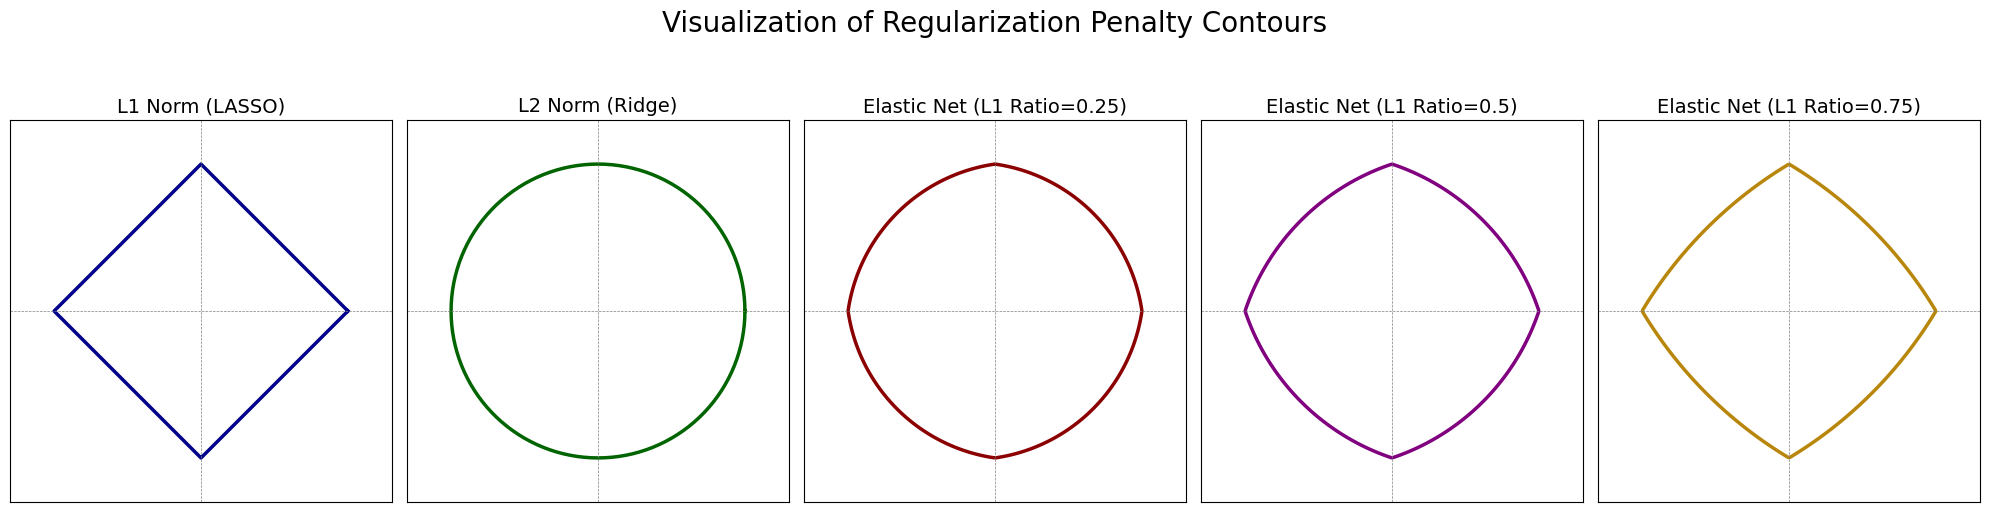

In [9]:
plot_eslastic_net()

Note the following about the difference between $L1$ (LASSO) and $L2$ (RIDGE) regularization techniques. 

1. For LASSO, the subgradient of the $L1$ penalty is constant along each flat 'face' of the diamond constraint (e.g., the vector $[\lambda, \lambda]$ in the positive quadrant). This is fundamentally different from RIDGE, where the gradient of the $L2$ penalty ($2\lambda\boldsymbol{\beta}$) is not constant as it changes continuously and always points radially outward from the origin.

2. The Ridge solution is the point of tangency between the elliptical RSS contour and the smooth, circular $L2$ constraint. Because a circle has no 'corners,' this tangency point is unlikely to be on an axis, so coefficients are shrunk towards zero but rarely to zero. In contrast, the LASSO solution occurs where the RSS contour hits the $L1$ 'diamond' constraint. This diamond has sharp corners located on the axes. It is geometrically far more probable for the expanding ellipse to hit one of these corners than to be perfectly tangent to a flat 'face.' Because these corners lie on the axes (e.g., where $\beta_1=0$), this property is precisely what enables LASSO to produce sparse solutions by forcing coefficients to exactly zero.

# 6 Advanced Topics

## 6.1 Confidence Intervals for LASSO Regression

**Part 1: The Problem: Why Traditional Confidence Intervals Fail for LASSO**

Traditional confidence intervals are not valid for LASSO because the very **act of selecting variables** with LASSO **invalidates** the statistical theory on which those intervals are built. This is a problem known as post-selection inference, and it is one of the most significant challenges in modern statistics.

A traditional confidence interval, like the one computed for OLS, is built on a crucial assumption:

* the model is fixed and was specified in advance.

When OLS is run on predictors $X_1, X_2, X_3$, the analyst is pre-committing to that model. The formula for the confidence interval, $\hat{\beta} \pm t_{\alpha/2} \times \text{se}(\hat{\beta})$, and the t-distribution (or normal distribution) it relies on, are all derived assuming this model was the only one ever considered.

LASSO, by its very design, breaks this assumption. It performs two tasks at once using the same set of data:

* **model selection**: It decides which predictors are important (i.e., which $\beta_j$ are not zero).
* **coefficient estimation**: It simultaneously estimates the values for those non-zero $\beta_j$.

This "data-snooping" results in "bias.", i.e. the data that was used to select the model is being reused to fit the model.

**Part 2: A Solution: The Polyhedral Lemma**

To construct a valid CI, one must formally account for the selection "bias." The field of post-selection inference does this by conditioning on the selection event. This is where the Polyhedral Lemma comes in.

1. The "Polyhedral Lemma" is the name for the insight derived from the LASSO's optimality conditions (specifically, the Karush-Kuhn-Tucker or KKT conditions). These optimality conditions are just a set of mathematical rules. For example, they state that for every non-zero coefficient $\hat{\beta}_j$, the "pull" from the data (the gradient of the RSS) must be exactly balanced by the "pull" from the $\lambda$ penalty. For every zero coefficient $\hat{\beta}_k$, the "pull" from the data must be weaker than the $\lambda$ penalty. This set of rules, when applied to the data matrix $\mathbf{X}$, defines a geometric shape in the high-dimensional space of possible outcomes ($\mathbf{y}$). This shape is a polyhedron ($\mathcal{P}$).

2. How This Builds a Confidence Interval. Now that a precise, geometric description of the selection event ($\mathbf{y} \in \mathcal{P}$) exists, it can be used to correct the biased statistic. The analysis is no longer working with a simple bell curve distribution. It is now working with a truncated distribution. All the properties of this new, truncated distribution can be calculated exactly because the exact geometry of the "cuts" (based on the Polyhedral Lemma) is known. Confidence intervals and p-values are then constructed based on this valid, conditional, truncated distribution. These "polyhedral" or "post-selection" CIs will be wider than the naive, incorrect ones, but they will have the correct coverage. They are statistically honest because they have properly accounted for the fact that the model itself was a product of the data.

**Part 3: Coding Implementation**

Luckily, the authors of LASSO (Tibshirani et al.) have released an R package to perform selective inference called `selectiveInference`, which is available on [CRAN](https://cran.r-project.org/web/packages/selectiveInference/index.html).

There is another package called `RegrCoeffsExplorer` which makes plotting CIs for LASSO hassle-free. It is available on [GitHub](https://github.com/vadimtyuryaev/RegrCoeffsExplorer) and [CRAN](https://cloud.r-project.org/web/packages/RegrCoeffsExplorer/index.html). In-depth examples and detailed discussions are included in the package documentation.

## 6.2 Automated $\lambda$ selection

### 6.2.1 Overview 

This Python script demonstrates a complete machine learning workflow for finding the optimal hyperparameters for a LASSO regression model using Bayesian Optimization.

The script performs the following steps.

1. Generates a Complex Dataset:
   * It creates a synthetic dataset of 1,000 samples and 20 features ($x0-x19$). All 20 features are "true" predictors, meaning they all have a non-zero effect on the target variable.
     
2. Injects Multicollinearity:
   * To make the problem challenging, it introduces two types of multicollinearity:
     * Linear: x1 is made correlated with x0.
     * Non-linear: x3 is made correlated with the cube of x2.
       
3. Adds Significant Noise: A high level of random noise is added to the target variable y. This is crucial as it causes a standard OLS model to overfit, making regularization (like LASSO) necessary to find a good predictive model.

4. Finds Optimal alpha: It uses Bayesian Optimization (from the `scikit-optimize` library) to intelligently search for the best alpha (regularization strength). The optimizer's goal is to find the alpha that minimizes the 5-fold cross-validated Mean Squared Error on the training data.

5. Trains & Evaluates: It trains a final LASSO model on the full training set using the best alpha found during optimization.

6. Reconstructs Coefficients

### 6.2.2.1 Libraries

In [2]:
# pip install scikit-optimize

In [7]:
import numpy as np
import pandas as pd
from typing import Tuple, Dict, List

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from skopt import gp_minimize
import skopt.space  # Import the whole module
from skopt.utils import use_named_args

### 6.2.2.2 Functions

In [8]:
def create_correlated_dataset(n_samples: int = 1000, n_features: int = 20) -> \
                               Tuple[pd.DataFrame, pd.Series, np.ndarray]:
    """
    Generates a dataset with 20 features and specific correlations.

    - Features 0 & 1: Linearly correlated
    - Features 2 & 3: Correlated at the cubic level
    - Features 4-19: Also related to y (no pure noise)
    - y: A linear combination of ALL 20 features, plus significant noise.
    """
    print(f"Generating dataset with {n_samples} samples and {n_features} features...")
    # The global np.random.seed(42) call at the top of the script
    # already ensures this function's operations are reproducible.
    
    # 1. Start with a base of random data
    X_data = np.random.rand(n_samples, n_features)
    
    # 2. Create the linear correlation (x1 = 0.9*x0 + noise)
    # Increased to 0.9 for stronger multicollinearity
    X_data[:, 1] = 0.9 * X_data[:, 0] + np.random.rand(n_samples) * 0.1
    
    # 3. Create the cubic correlation (x3 = 0.7*x2^3 + noise)
    X_data[:, 3] = 0.7 * (X_data[:, 2]**3) + np.random.rand(n_samples) * 0.05
    
    # 4. Define the true coefficients
    # All 20 features will have an effect.
    true_coefficients = np.zeros(n_features)
    true_coefficients[0] = 5.0   # Coeff for x0
    true_coefficients[1] = -3.5  # Coeff for x1 (linear)
    true_coefficients[2] = 2.0   # Coeff for x2
    true_coefficients[3] = -1.5  # Coeff for x3 (cubic)
    
    # Assign non-zero coefficients to the remaining 16 features
    # Use a reproducible random draw for these coefficients
    true_coefficients[4:] = np.random.uniform(-2.5, 2.5, size=n_features - 4)
    
    # 5. Create the target variable 'y'
    # y is a linear combination of the features, using the true coefficients
    # We increase the noise here (e.g., to 7.0) to make the model
    # overfit, giving the LASSO alpha a reason to increase.
    y_noise_std = 2.0
    y_data = X_data @ true_coefficients + np.random.randn(n_samples) * y_noise_std
    
    # 6. Create a DataFrame for clarity
    feature_names = [f'x{i}' for i in range(n_features)]
    X_df = pd.DataFrame(X_data, columns=feature_names)
    y_series = pd.Series(y_data, name='y')
    
    return X_df, y_series, true_coefficients


def run_bayesian_optimization(X_train: pd.DataFrame, y_train: pd.Series) -> float:
    """
    Runs Bayesian Optimization to find the best 'alpha' for LASSO.
    
    The optimizer works by minimizing an objective function. Our objective
    function will be the cross-validated Mean Squared Error (MSE).
    """
    print("\nStarting Bayesian Optimization for LASSO 'alpha'...")
    
    # 1. Define the search space for 'alpha'
    # We search on a log scale, as alpha's effect is multiplicative.
    search_space = [
        # Use the fully qualified name to avoid NameError
        skopt.space.Real(1e-6, 100.0, prior='log-uniform', name='alpha')
    ]
    
    # 2. Define the objective function
    # This function will be called by the optimizer.
    # It takes 'alpha' as input and returns the error score to minimize.
    @use_named_args(search_space)
    def objective(alpha: float) -> float:
        """
        Objective function for the optimizer.
        Returns the average cross-validated Mean Squared Error.
        """
        # We MUST use a pipeline to scale data correctly inside
        # each cross-validation fold. This prevents data leakage.
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('lasso', Lasso(alpha=alpha, tol=0.01, max_iter=2000, random_state=42))
        ])
        
        # Get cross-val scores. We use 'neg_mean_squared_error'
        # which returns negative MSE (e.g., -0.25)
        scores = cross_val_score(
            pipeline,
            X_train,
            y_train,
            cv=5,  # 5-fold cross-validation
            scoring='neg_mean_squared_error'
        )
        
        # We want to MINIMIZE the error. 'scores' are negative.
        # So we take the mean (e.g., -0.25) and return its
        # absolute value (0.25). The optimizer will minimize this.
        return np.abs(np.mean(scores))

    # 3. Run the optimization
    # n_calls = number of times to call the 'objective' function
    # n_initial_points = how many times to sample randomly before building the model
    result = gp_minimize(
        objective,
        search_space,
        n_calls=30,
        n_initial_points=10,
        random_state=42,
        verbose=False
    )
    
    best_alpha = result.x[0]
    best_mse = result.fun
    
    print(f"Optimization complete.")
    print(f"Best 'alpha' found: {best_alpha:.6f}")
    print(f"Corresponding Cross-Validated MSE: {best_mse:.6f}")
    
    return best_alpha

### 6.2.2.3 Bayesian Optimization 

In [12]:
def bayes_opt_lasso():
    """
    Main function to run the full workflow.
    """
    # 1. Generate the complex dataset
    X, y, true_coefficients = create_correlated_dataset(n_samples=1000, n_features=20)
    
    # 2. Split data into training and a final, held-out test set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # 3. Find the best hyperparameter (alpha) using only the training data
    best_alpha = run_bayesian_optimization(X_train, y_train)
    
    # 4. Train the final model
    # We build the final pipeline and train it on the *entire*
    # training set, using the optimal alpha we just found.
    print("\nTraining final model with best 'alpha'...")
    final_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(alpha=best_alpha, random_state=42))
    ])
    
    final_pipeline.fit(X_train, y_train)
    
    # 5. Evaluate the final model on the held-out test set
    # This gives an unbiased estimate of its performance.
    y_pred = final_pipeline.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    print(f"Final Model MSE on (unseen) test data: {test_mse:.6f}")
    
    # 6. Reconstruct and compare coefficients
    print("\n--- Coefficient Reconstruction ---")
    
    # Get components from the trained pipeline
    scaler = final_pipeline.named_steps['scaler']
    lasso_model = final_pipeline.named_steps['lasso']
    
    # The model's coefficients are for the *scaled* data.
    recovered_coeffs_scaled = lasso_model.coef_
    
    # To compare them to our true coefficients, we must un-scale them.
    # The formula is: unscaled_coeff = scaled_coeff / scaler.scale_
    # We must handle division by zero if a feature had zero variance (unlikely)
    scaler_scale = scaler.scale_
    scaler_scale[scaler_scale == 0] = 1.0  # Avoid division by zero
    
    recovered_coeffs_unscaled = recovered_coeffs_scaled / scaler_scale
    
    # 7. Display results in a clear table
    results_df = pd.DataFrame({
        'Feature': X.columns,
        'True Coefficient': true_coefficients,
        'Recovered Coefficient (LASSO)': recovered_coeffs_unscaled
    })
    
    # Round for clarity
    results_df['True Coefficient'] = \
        results_df['True Coefficient'].round(8)
        
    # FIX: Corrected the typo from 'RecoverED' to 'Recovered'
    results_df['Recovered Coefficient (LASSO)'] = \
        results_df['Recovered Coefficient (LASSO)'].round(8)
        
    print(results_df.to_string())

    # --- Analysis of Results ---
    # We have 20 true predictors. We expect LASSO to shrink
    # all coefficients, but ideally, it should not zero out
    # any *true* predictors. With correlated features, it will be
    # interesting to see how it distributes the coefficients.


### 6.2.2.4 Automated $\lambda$ Selection  

In [13]:
# Set a random seed for reproducibility
np.random.seed(42)

# Run the optimization
bayes_opt_lasso()

Generating dataset with 1000 samples and 20 features...

Starting Bayesian Optimization for LASSO 'alpha'...
Optimization complete.
Best 'alpha' found: 0.026551
Corresponding Cross-Validated MSE: 4.210436

Training final model with best 'alpha'...
Final Model MSE on (unseen) test data: 4.216186

--- Coefficient Reconstruction ---
   Feature  True Coefficient  Recovered Coefficient (LASSO)
0       x0          5.000000                       1.401596
1       x1         -3.500000                       0.000000
2       x2          2.000000                       1.042879
3       x3         -1.500000                      -0.000000
4       x4          1.323180                       1.340618
5       x5         -2.467418                      -2.326836
6       x6         -0.114750                      -0.243877
7       x7          1.469522                       1.427191
8       x8          0.650224                       0.956561
9       x9         -0.129684                      -0.245890
10     x

To minimize the $L1$ penalty, LASSO discarded the redundant $x1,x3$ features from the correlated pairs, demonstrating its power in handling multicollinearity.